<a href="https://colab.research.google.com/github/YTHsieh/GEE_Python/blob/master/GEEtoXarray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Set the Earth Engine library environment

First cell of this notebook is for installing the EE api.

In [1]:
!pip install earthengine-api
!earthengine authenticate

     |████████████████████████████████| 153kB 2.7MB/s 
  Created wheel for earthengine-api: filename=earthengine_api-0.1.201-cp36-none-any.whl size=174588 sha256=96f9b9a90059021ea46ade4c152d960cccd588071d2274f1fc5ba533da6f2065
  Stored in directory: /root/.cache/pip/wheels/82/fc/19/f4e9a7b8e7653e36a17654612a05beda94d065c37b3b0eaff7
Successfully built earthengine-api
Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

/usr/local/lib/python3.6/dist-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleuse

In [0]:
# Import the Earth Engine library and other needed library.
import ee
# Initialize the library.
ee.Initialize()

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time

import xarray as xr
import datetime
import pandas as pd

In [0]:
# Set roi and date range of whole project.
roi = ee.Geometry.Polygon(
        [[[121.23870041204202, 24.396233251172916],
          [121.23908665014017, 24.393380125775813],
          [121.24110367131937, 24.39201216609032],
          [121.24359276128519, 24.391464978069234],
          [121.2497725708555, 24.393341041418914],
          [121.25003006292093, 24.397210334099846]]], None, False)
satellite = "LANDSAT/LC08/C01/T1_SR"
start = "2015-01-01"
end = "2018-12-31"


In [34]:
# 建立函數 返回符合時間範圍的Img ID (type: nd.array) 
def getImgId(satellite, startDate, endDate):
  # Load a matched imagecollection
  imgCollection = ee.ImageCollection(satellite).filterBounds(roi).filterDate(startDate, endDate)
  imgNameList = np.array(imgCollection.aggregate_array("system:index").getInfo(), dtype = str)
  satellitenames = np.repeat(satellite + "/", imgNameList.size)
  finalList = np.char.add(satellitenames, imgNameList)
  return finalList
test = getImgId(satellite, start, end)
print(test, type(test))

['LANDSAT/LC08/C01/T1_SR/LC08_117043_20150116'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20150201'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20150217'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20150305'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20150321'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20150406'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20150422'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20150508'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20150609'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20150625'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20150711'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20150727'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20150812'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20150913'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20151015'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20151031'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20151116'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20151202'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20151218'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20160119'
 'LANDSAT/LC08/C01/T1_SR/LC08_117043_20160307'
 'LANDSAT/LC0

In [0]:
# link all stack function; filled with nan value  

def stackImg(imgList):
  # Construct a list first, to store each xarray.
  list_of_data_arrays = []
  
  for x in np.nditer(imgList):
        # Load a S2 image
        img = ee.Image(str(x))
  
        # do any ee operation here
        ndvi = ee.Image(img.normalizedDifference(['B5', 'B4']))
        timedate = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd').getInfo()
  
        # get the lat lon and add the ndvi
        latlon = ee.Image.pixelLonLat().addBands(ndvi)
  
        # apply reducer to list
        latlon = latlon.reduceRegion(
          reducer=ee.Reducer.toList(),
          geometry=roi,
          maxPixels=1e8, #check
          scale=30)
  
        # get data into three different arrays
        data = np.array((ee.Array(latlon.get("nd")).getInfo()))
        lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
        lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))
  
        # get the unique coordinates
        uniqueLats = np.unique(lats)
        uniqueLons = np.unique(lons)
  
        # get number of columns and rows from coordinates
        ncols = len(uniqueLons)    
        nrows = len(uniqueLats)
  
        # determine pixelsizes
        ys = uniqueLats[1] - uniqueLats[0] 
        xs = uniqueLons[1] - uniqueLons[0]
  
        # create an array with dimensions of image
        arr = np.empty([nrows, ncols], np.float64) #-9999
        arr.fill(np.nan)
  
        # fill the array with values
        counter =0
        for y in range(0,len(arr),1):
          for x in range(0,len(arr[0]),1):
              if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                  counter+=1
                  arr[-(len(uniqueLats)-y),x] = data[counter] # we start from lower left corner
  
        # Construct a xarray, fill in with ndarray.
        da = xr.DataArray(arr, coords=[uniqueLats, uniqueLons], dims = ['lat', 'lon'])
        time_obj = datetime.datetime.strptime(timedate, "%Y-%m-%d")
        da.coords['time'] = time_obj
  
        # Construct a list to store each xarray.
        list_of_data_arrays.append(da)
  
  combined = xr.concat(list_of_data_arrays, dim = 'time')
  return combined

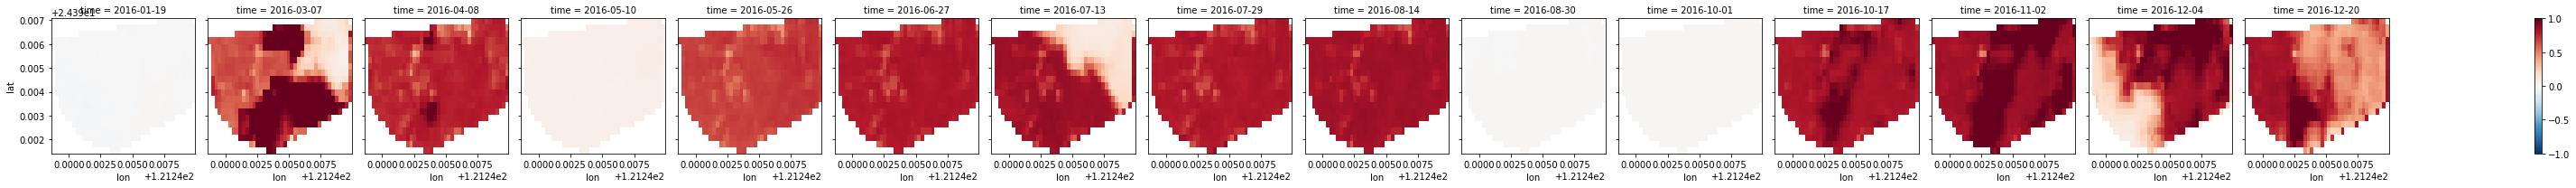

In [10]:
## Print to check function: stackImg()
stackImg(test).plot.imshow(col = 'time', robust = True)

In [0]:
## Correct version of matchImg
def matchImg(Imgstack,startDate,endDate):
  #Get data of dim:'time'
  ts = pd.to_datetime([startDate])
  ts2 = pd.to_datetime([endDate])
  dif_ts = np.array((ts2-ts)//np.timedelta64(1,'D'), dtype = np.int)
  tt = pd.date_range(startDate, periods = dif_ts[0], freq='D')
  
  ntime = len(tt)
  
  arr = np.empty([len(Imgstack.lat), len(Imgstack.lon), ntime], np.float64) #-9999
  arr.fill(np.nan) #fill the arr with np.nan.
  
  da = xr.DataArray(arr,dims=['lat', 'lon', 'time'], coords={'lat': Imgstack.lat, 'lon': Imgstack.lon, 'time': tt})
  return xr.concat((da,Imgstack),'z').mean(dim='z')

In [7]:
print(matchImg(stackImg(test), start, end))
matchImg(stackImg(test), start, end).plot.imshow(col = 'time', robust = True)

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray (lat: 21, lon: 42, time: 365)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2016-12-30
  * lat      (lat) float64 24.39 24.39 24.39 24.39 24.39 ... 24.4 24.4 24.4 24.4
  * lon      (lon) float64 121.2 121.2 121.2 121.2 ... 121.2 121.2 121.2 121.2


ValueError: ignored

ValueError: ignored

<Figure size 78912x216 with 365 Axes>

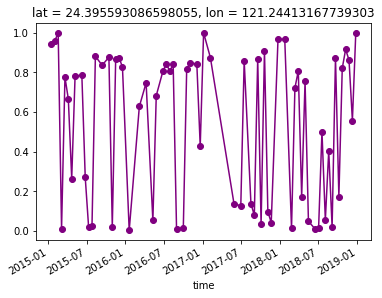

In [37]:
# Plot the stackImg time-series
NDVI1d = stackImg(test).isel(lat=15, lon=20)
NDVI1d.plot.line(color='purple', marker='o')

#NDVI1d2 = matchImg(stackImg(test), start, end).isel(lat=15, lon=20)
#NDVI1d2.plot.line(color='purple', marker='o')



/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


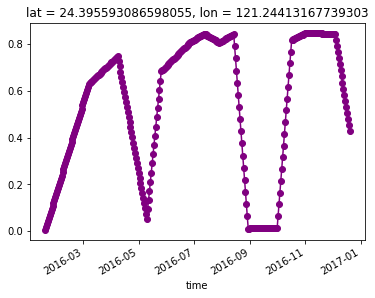

In [24]:
NDVItimeseries = matchImg(stackImg(test), start, end).isel(lat=15, lon=20).interpolate_na(dim='time', method = 'linear')
NDVItimeseries.plot.line(color='purple', marker='o')

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


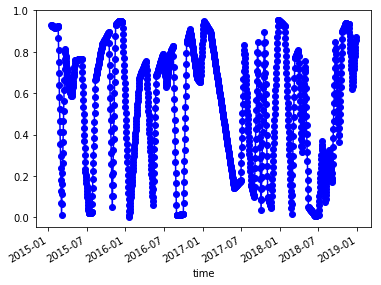

In [38]:
## Plot mean NDVI of the area, interpolate NA value at each time stamp.
NDVI_mean = matchImg(stackImg(test), start, end).mean(dim=('lat', 'lon')).interpolate_na(dim='time', method = 'linear')
NDVI_mean.plot.line(color='blue', marker='o')

In [39]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [40]:
!ls

drive  sample_data


In [42]:
!pip install -q netCDF4
!pip install --upgrade netCDF4

     |████████████████████████████████| 4.1MB 2.8MB/s 
     |████████████████████████████████| 307kB 53.7MB/s 
Requirement already up-to-date: netCDF4 in /usr/local/lib/python3.6/dist-packages (1.5.2)


In [43]:
## Save final xarray to netCDF4 file.
matchImg(stackImg(test), start, end).to_netcdf('/content/drive/My Drive/Colab Notebooks/NetCDF/saved_on_disk.nc', format="netCDF4")

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
